# STEM Week 8 Processing Signals

This week we will learn about several statistical techniques used on audio, image or sensor data. 

Often these are used as pre-processing techniques to regularise often noisy data for further processing (e.g. machine learning).

They can also be used to highlight differences in a signal. This means that when we try to get a learning algorithm to model them, its job is easier.

When used in this way to help construct a dataset, we might call this approaches **feature engineering**.

## Audio

Adapted from [this tutorial](https://colab.research.google.com/github/stevetjoa/musicinformationretrieval.com/blob/gh-pages/basic_feature_extraction.ipynb#scrollTo=dp0cfkzSNCXo)


### Feature Extraction

Somehow, we must extract the characteristics of our audio signal that are most relevant to the problem we are trying to solve. For example, if we want to classify instruments by timbre, we will want features that distinguish sounds by their timbre and not their pitch. If we want to perform pitch detection, we want features that distinguish pitch and not timbre.

This process is known as feature extraction.

First we'll load in two sets of audio files, each representing a different drum type.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import librosa, sklearn
from sklearn import preprocessing

We want to search through a folder, and return the paths of any files that meet a certain pattern. This is a really common task for loading in datasets from file.

We are going to see first how we can find that list, then how we can use that list to make a new collection of loaded in audio files.

#### `glob`

This will search a given directory for files matching a pattern and return a list of file paths.

We can use the `*` wildcard symbol to mean `anything in between`

#### `List Comprehensions`

We're going to use something called a List comprehension in this next step. These are a quick way of making new arrays. They follow the format 

`[function for item in list]`

This is the same as 

```
for item in list:
    function(item)
```

We can also save the result 

```
new_list = [function(item) for item in old_list] 
```

Where `new_list` is the result of taking all of the elements in `old_list` and passing it as an argument to `function`. The code below does the same thing using a for loop.

```
new_list = []
for item in list:
    new_item = function(item)
    new_list.add(new_item)
```



In [2]:
#Get file paths and load audio, saving the result in a new array
hihat_filepaths = Path().glob('audio/drum_hits/hihat_*.WAV')
hihat_signals = [librosa.load(p)[0] for p in hihat_filepaths]

snare_filepaths = Path().glob('audio/drum_hits/snare_*.WAV')
snare_signals = [librosa.load(p)[0] for p in snare_filepaths]

print(len(hihat_signals),len(snare_signals))

37 49


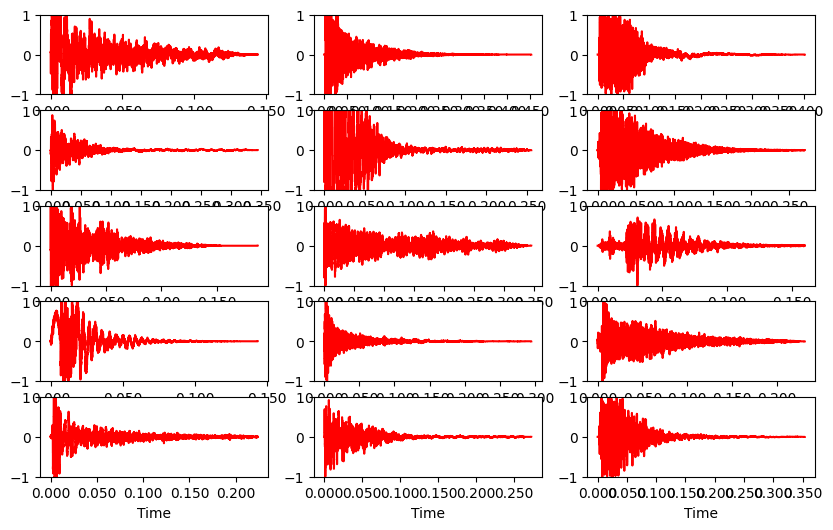

In [40]:
#Look at the waveforms of the first 10
plt.figure(figsize=(10, 6))
for i, x in enumerate(snare_signals[:15]):
    plt.subplot(5, 3, i+1)
    librosa.display.waveshow(x[:10000], color = "red")
    plt.ylim(-1, 1)

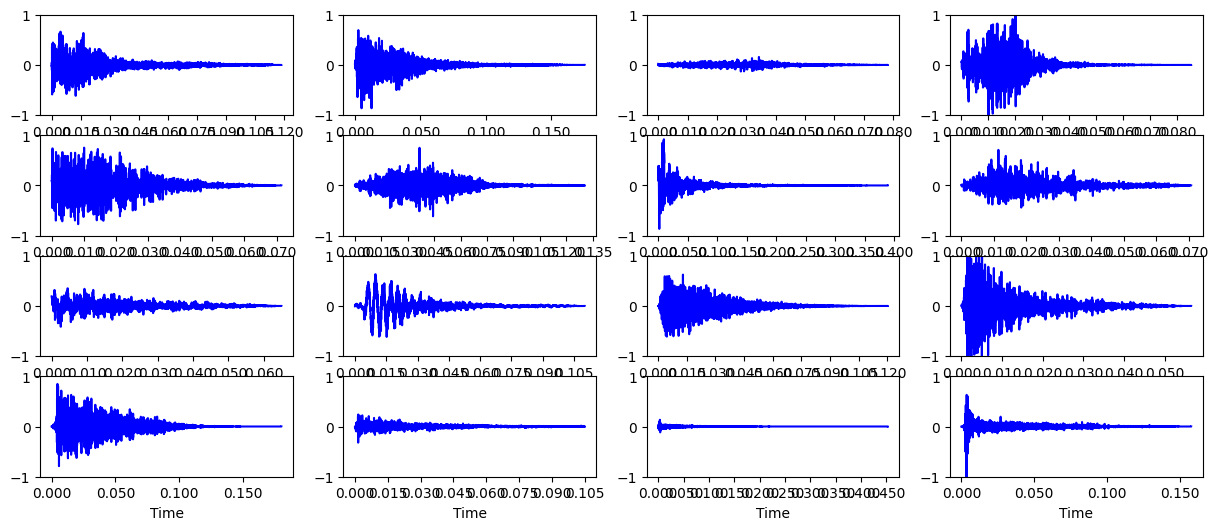

In [38]:
#Look at the waveforms of the first 10
plt.figure(figsize=(15, 6))
for i, x in enumerate(hihat_signals[:16]):
    plt.subplot(4, 4, i+1)
    librosa.display.waveshow(x[:10000], color = "blue")
    plt.ylim(-1, 1)

### Extracting features

A feature vector is simply a **list of numbers** which represent **each item** in our dataset. It should provide highlight properties that are useful for whatever analysis we are doing. 

#### Zero Crossing Rate 

Tells us how often the signal is going from **negative to positive**, and vice versa.

Zero crossing rate can be used as a feature to help distinguish between different instruments or sound sources. Instruments with different timbres often exhibit distinct zero crossing rate patterns. For example, percussive instruments like **drums** may have a **higher zero crossing rate** compared to **sustained instruments like strings or woodwinds**.

#### Spectral Centroid

Spectral centroid is commonly used to describe the **timbral characteristics of audio signals**. It can help distinguish between sounds that are **bright** or **sharp** in timbre (higher centroid values) and sounds that are **dull** or **mellow** (lower centroid values). For example, a violin's sound typically has a higher spectral centroid than that of a bass drum.

This formula shows us how to calculate the Spectral Centroid, given we have first calculated an `fft`. 

For each bin, we take the centre frequency of that bin (`f(n)`), and multiply it by the magnitude (`X(n)`) (e.g. the strength of the signal in that bin). We sum this up and divide by the sum of all the magnitudes.

<br>

$$
\text{Spectral Centroid} = \frac{\sum_{n=0}^{N}{f(n) \cdot X(n)}}{\sum_{n=0}^{N}{X(n)}}
$$
<br>

In [5]:
librosa.feature.zero_crossing_rate(y=hihat_signals[10])

array([[0.35595703, 0.53662109, 0.71777344, 0.67626953, 0.50537109,
        0.32470703]])

In [6]:
librosa.feature.spectral_centroid(y=hihat_signals[10])

array([[5613.9883628 , 5744.68434826, 6033.4673592 , 6319.15600068,
        6464.8515545 , 6362.63819493]])

Here is a simple function that constructs a two-dimensional feature vector from a signal. 

Each feature extractor returns **an array of values over a number of frames**. We take the **mean** of that array to return 3 numbers for each audio file.

In [7]:
def extract_features(signal):
    return [
        librosa.feature.zero_crossing_rate(y=signal).mean(),
        librosa.feature.spectral_centroid(y=signal, n_fft=512).mean(),
        librosa.feature.rms(y=signal).mean()
    ]

If we want to aggregate all of the feature vectors among signals in a collection, we can use a list comprehension as follows:

In [8]:
hihat_features = np.array([extract_features(x) for x in hihat_signals])
snare_features = np.array([extract_features(x) for x in snare_signals])
print(hihat_features.shape, snare_features.shape)

(37, 3) (49, 3)


Visualize the differences in features by plotting separate histograms for each of the classes: First we see how amplitude information (``RMS`` or ``root-mean-squared``) doesnt really distinguish between the two classes (lots of cross over between red and blue histograms). Our next two (``zero crossing rate`` and `spectral centroid`) are much better feature representations 

Text(0, 0.5, 'Count')

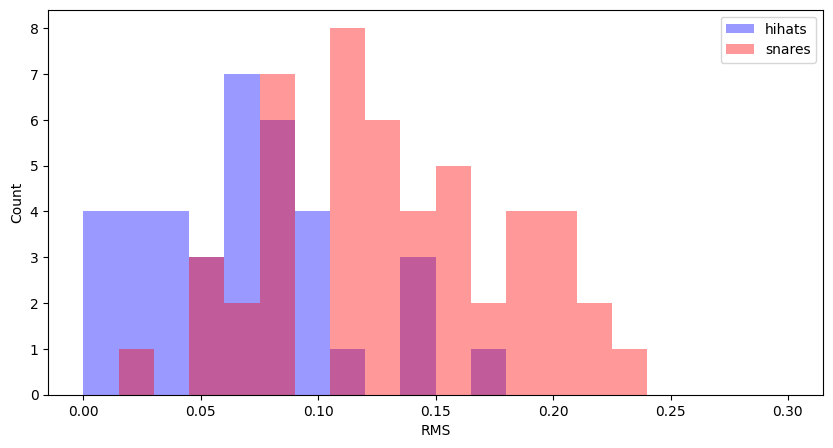

In [47]:
plt.figure(figsize=(10, 5))
plt.hist(hihat_features[:,2], color='b', range=(0, 0.3), alpha=0.4, bins=20)
plt.hist(snare_features[:,2], color='r', range=(0, 0.3), alpha=0.4, bins=20)
plt.legend(('hihats', 'snares'))
plt.xlabel('RMS')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

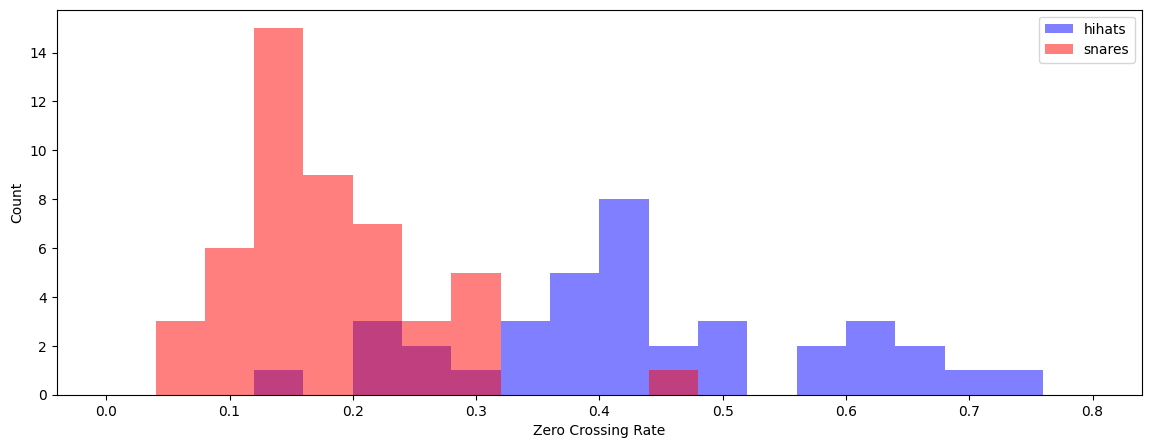

In [49]:
plt.figure(figsize=(14, 5))
plt.hist(hihat_features[:,0], color='b', range=(0, 0.8), alpha=0.5, bins=20)
plt.hist(snare_features[:,0], color='r', range=(0, 0.8), alpha=0.5, bins=20)
plt.legend(('hihats', 'snares'))
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

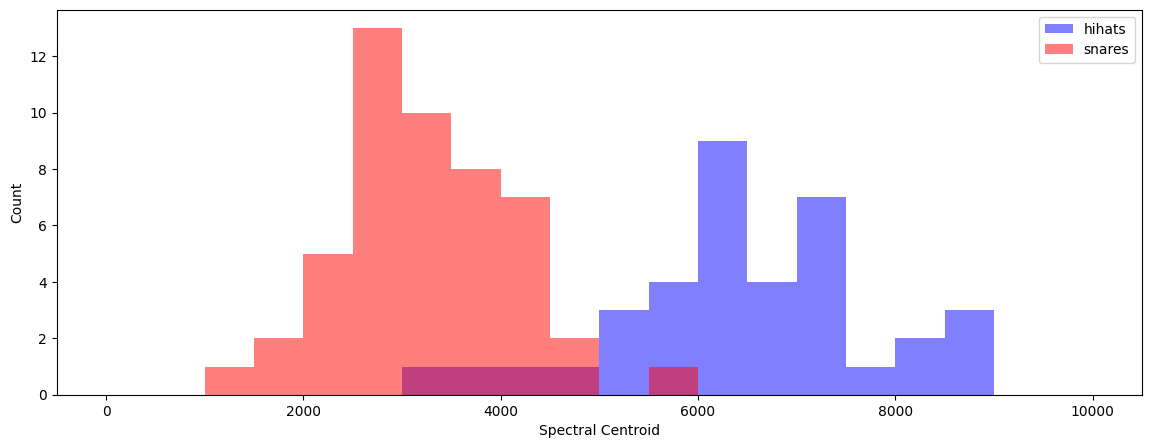

In [11]:
plt.figure(figsize=(14, 5))
plt.hist(hihat_features[:,1], color='b', range=(0, 10000), alpha=0.5, bins=20)
plt.hist(snare_features[:,1], color='r', range=(0,10000), alpha=0.5, bins=20)
plt.legend(('hihats', 'snares'))
plt.xlabel('Spectral Centroid')
plt.ylabel('Count')

## Feature Scaling

The features that we used in the previous example included zero crossing rate and spectral centroid. These two features are expressed using different units. This discrepancy can pose problems when performing classification later. Therefore, we will normalize each feature vector to a common range and store the normalization parameters for later use.  

Many techniques exist for scaling your features. For now, we'll use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).  `MinMaxScaler` returns an array of scaled values such that each feature dimension is in the range 0 to 1.

The formula below describes how we would calculate each new scaled point. We would subtract the minimum value in the sequence, then divide each point by the difference between the maximum and minimum values

<br>

$$
\text{Min-Max Scaling:} \quad X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$

<br>

Let's concatenate all of our feature vectors into one *feature table*. We need them to both be in one collection in order to do the above calculation properly. 

In [12]:
feature_table = np.vstack((hihat_features, snare_features))
print(feature_table.shape)

(86, 3)


Scale each feature dimension to be in the range 0 to 1

In [13]:
scaler = preprocessing.MinMaxScaler()
training_features = scaler.fit_transform(feature_table)
print(training_features.min(axis=0))
print(training_features.max(axis=0))

[0. 0. 0.]
[1. 1. 1.]


Text(0, 0.5, 'Spectral Centroid')

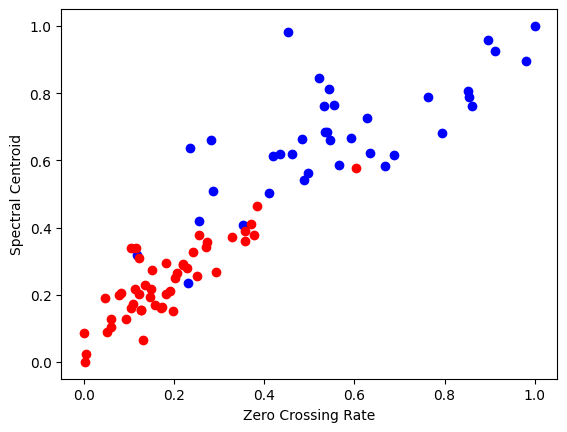

In [14]:
split = len(hihat_features)
plt.scatter(training_features[:split,0], training_features[:split,1], c='b')
plt.scatter(training_features[split:,0], training_features[split:,1], c='r')
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Spectral Centroid')

## Images

Adapted from [Mick Griersons notebook](https://github.com/ual-cci/MSc-Coding-2/blob/master/Week-6-Exercise-intro-to-image-data-and-tensorflow.ipynb)

We are going to look at ways of preprocessing an image dataset. This can itself reveal interesting things about the data, as well as making later machine learning easier by highlighting where the differences between our images are.

In [15]:
import cv2

In [16]:
image_paths = Path().glob('images/originals/*.jpg')
full_portraits = np.array([plt.imread(p) for p in image_paths])
len(full_portraits)

1452

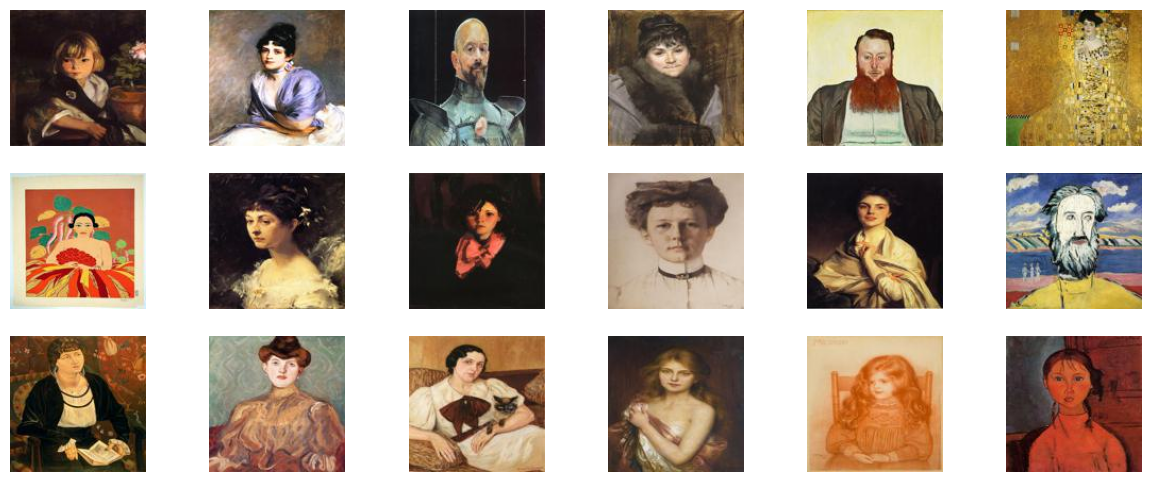

In [17]:
#Get 18 random pictures 
indexes = np.random.randint(0, len(full_portraits), 18)
images_to_show = full_portraits[indexes]

plt.figure(figsize=(15, 6))
for index, image in enumerate(images_to_show):
    #display on a grid of 3 rows and 6 columns (3x6=18)
    plt.subplot(3, 6, index+1)  
    plt.axis('off')
    plt.imshow(image)

### How much variation is in the dataset?

We can look at the `mean` of the dataset along the first axis in order to see the average picture. The result is quite a blurry one with not much distinguishing features, suggesting that there is little consensus to our dataset when think about each picture laid on top of each other.

We can also view the `standard deviation` of our dataset. Again, this is fairly uniform and doesnt really highlight any areas of the canvas that have more variation than others.

If we are trying to highlight where the interesting parts will be in our dataset, this isn't a particularly useful representation as theres so much variation 

### Standard Deviation

Standard Deviation tells us how much variance there is a set of data

**Variance** is the mean distance from the mean of the group

**Standard Deviation** is the square root of this

<br>

$$
\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}
$$

<br>

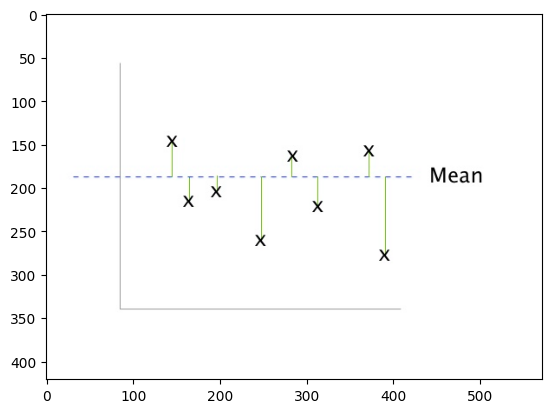

In [18]:
trig = cv2.imread('images/stdev.jpg')
plt.imshow(trig.astype(np.uint8))

look at this average person


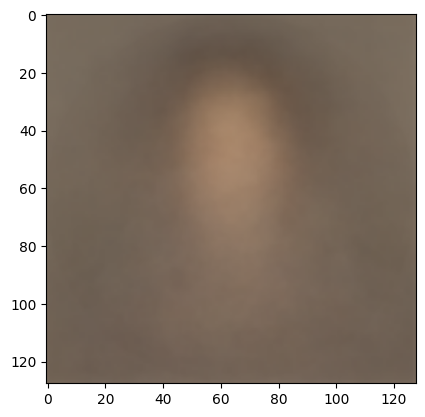

In [19]:
mean_img = np.mean(full_portraits, axis=0) # This is the mean of the 'batch' channel
plt.imshow(mean_img.astype(np.uint8))
print("look at this average person")

This is the standard deviation - the variance of the mean


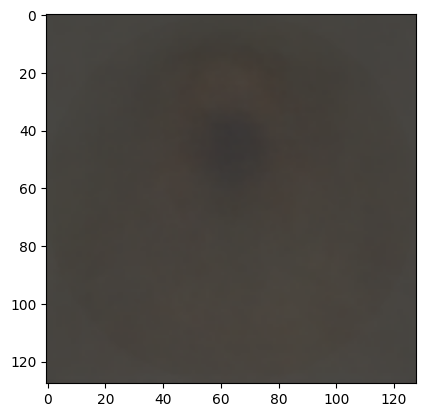

In [20]:
std_img = np.std(full_portraits, axis=0)
plt.imshow(std_img.astype(np.uint8))
print("This is the standard deviation - the variance of the mean")

### Aligning Faces

One thing that will help us here is to find the faces and align them with the eyes parallel to the base. When we know that all the images are of mainly faces, and with similar orientations, then hopefully the `mean` and `standard deviation` will reveal some interesting information about where the variation in the faces is.



In [21]:
#Load in aligned dataset
faces = np.array([plt.imread(p) for p in Path().glob('images/aligned_faces/*.jpg')])
len(faces)

731

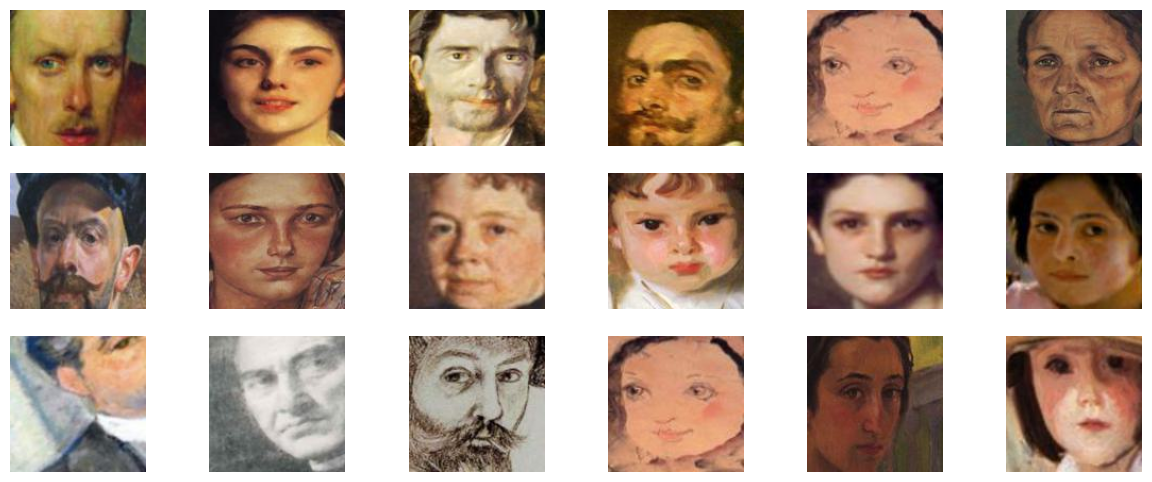

In [58]:
#Get 18 random pictures 
indexes = np.random.randint(0, len(faces), 18)
images_to_show = faces[indexes]

plt.figure(figsize=(15, 6))
for index, image in enumerate(images_to_show):
    #display on a grid of 3 rows and 6 columns (3x6=18)
    plt.subplot(3, 6, index+1)  
    plt.axis('off')
    plt.imshow(image)

look at this average person


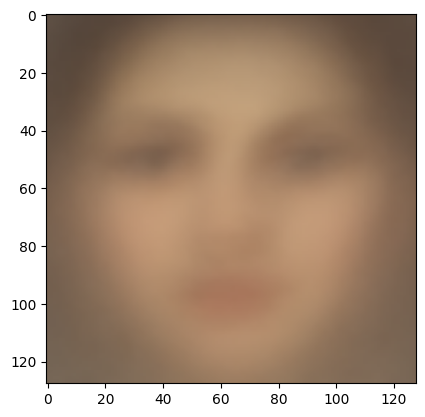

In [59]:
mean_img = np.mean(faces, axis=0) # This is the mean of the 'batch' channel
plt.imshow(mean_img.astype(np.uint8))
print("look at this average person")

Immediately we see a much clearer face like structure in our mean picture. 

This is the standard deviation - the variance of the mean


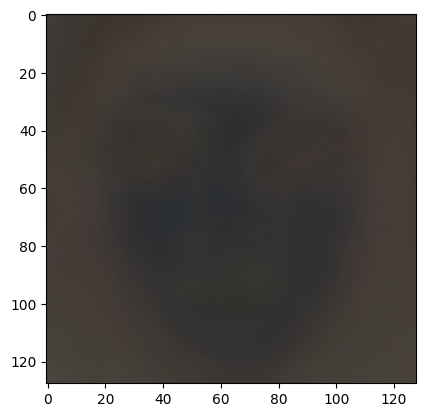

In [61]:
std_img = np.std(faces, axis=0)
plt.imshow(std_img.astype(np.uint8))
print("This is the standard deviation - the variance of the mean")

We've just shown where changes are likely to be in our dataset of images. Or put another way, we're showing where and how much variance there is in our previous mean image representation.

We're looking at this per color channel. So we'll see variance for each color channel represented separately, and then combined as a color image. 

In [25]:
std_img.shape

(128, 128, 3)

As an alternative, we can try to look at the average variance over all color channels by taking their mean:

Mean of all colour channels


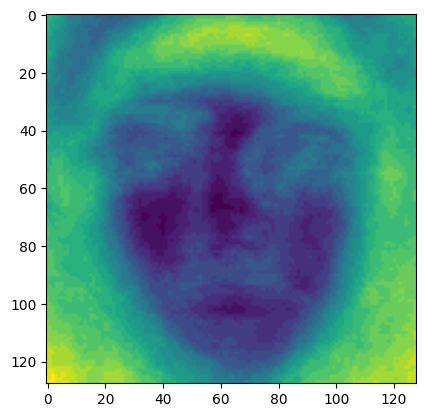

In [26]:
plt.imshow(np.mean(std_img, axis=2).astype(np.uint8)) # Mean of all colour channels (keep the spatial dimensions across wxh, squash c)
print("Mean of all colour channels")

This is showing us on average, how each pixel will vary as a heatmap. The more red, the more variation in the dataset and the less useful the mean is at representing it. The more blue, the more likely that our mean image is representative of the interesting parts of the images in our dataset.

### How did we align the faces?

First we used `openCV` to get the bounding boxes for the face and the eyes in the picture

In [32]:
from faces import get_face, get_eyes
full_portrait = plt.imread("images/portraits/spyros-papaloukas_3.jpg")
face, fx, fy, fw, fh = get_face(full_portrait.copy())
plt.imshow(face.astype(np.uint8))


FileNotFoundError: [Errno 2] No such file or directory: 'images/portraits/spyros-papaloukas_3.jpg'

In [73]:
eyes, left_eye_x,left_eye_y, right_eye_x, right_eye_y = get_eyes(full_portrait.copy(),fx,fy,fw,fh)
plt.imshow(eyes.astype(np.uint8))

NameError: name 'fx' is not defined

### Trigonometry Refresher 

Here we have a right angled triangle, it has 3 angles and 3 sides. If we know some of these things, then we are able to work out some of the **unknowns**. 

We name the sides of the triangle in the relation to the **right angle**. This is the angle which is 90 degrees in te corner. The three respective sides are 

 - Adjacent 
 - Opposite 
 - Hypotenuse 

### Calculating Theta 

What we want to know is the angle in the corner of the triangle (shown by the greek symbol **Theta θ**). This will allow us to rotate the image back so that the face is aligned parallel in the image. 

If we look at the triangle we have made between the eyes, we know that have the values for the **adjacent** and **opposite** sides. Using the above rules, we can see that 

tan(θ) = opp/adj

And by doing a bit of algebra, we do the opposite operation to tan to both sides to solve for θ. This is called **arctan**, and this exists for both sin (**arcsin**) and cos (**arccos**).

θ = arctan(opp/adj)

For all types of problems involving **right angled** triangles and you are looking to calculate **lengths** or **angles**, you can use the appropriate formula depending on what you know, and what you need to find out. 

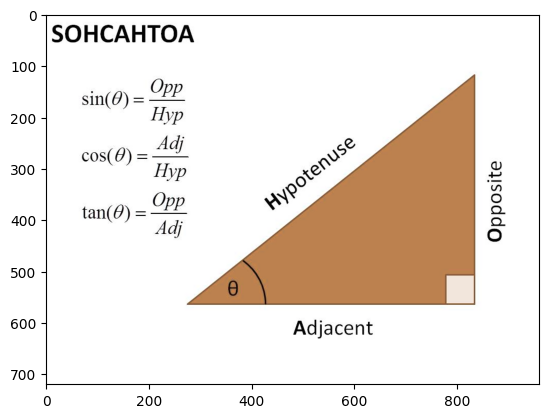

In [62]:
trig = cv2.imread('images/sohcahtoa.jpg')
plt.imshow(trig.astype(np.uint8))

In [63]:
adjacent = right_eye_x - left_eye_x
opposite = right_eye_y - left_eye_y
angle = np.arctan(opposite/adjacent)
#Convert from radians into degrees
angle = (angle * 180) / np.pi
h, w = full_portrait.shape[:2]
center = (int(fx),int(fy))
M = cv2.getRotationMatrix2D(center, (angle), 1.0)
rotated = cv2.warpAffine(full_portrait, M, (w, h))
face = rotated[fy:(fy+fh), fx:(fx+fw)]
plt.imshow(face.astype(np.uint8))

NameError: name 'right_eye_x' is not defined

### Histograms

Let's have a look at our dataset another way to see why this might be a useful thing to do.

 We're first going to convert our batch x height x width x channels array into a 1 dimensional array. Instead of having 4 dimensions, we'll now just have 1 dimension of every pixel value stretched out in a long vector, or 1 dimensional array

In [64]:
flattened = faces.ravel()

We first convert our N x H x W x C dimensional array into a 1 dimensional array.  The values of this array will be based on the last dimensions order.  So we'll have: [<font color='red'>251</font>, <font color='green'>238</font>, <font color='blue'>205</font>, <font color='red'>251</font>, <font color='green'>238</font>, <font color='blue'>206</font>, <font color='red'>253</font>, <font color='green'>240</font>, <font color='blue'>207</font>, ...]

We can visualize what the "distribution", or range and frequency of possible values are. This is a very useful thing to know. It tells us whether our data is predictable or not.

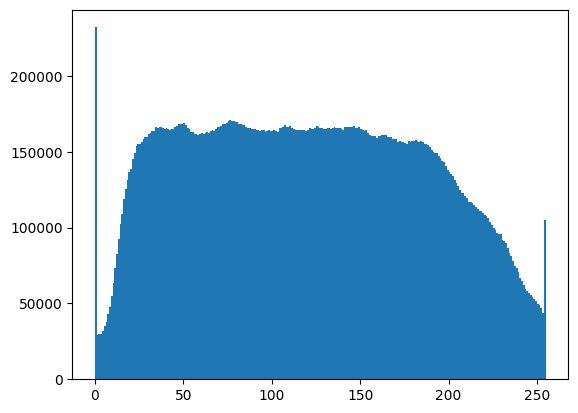

In [75]:
a = plt.hist(flattened, 255)

Text(0.5, 1.0, 'b')

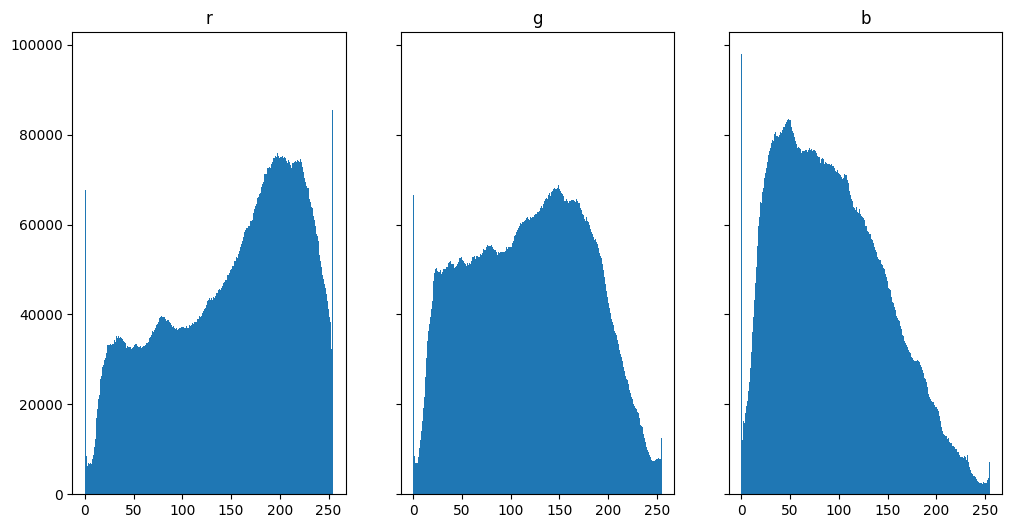

In [66]:
bins = 255
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axs[0].hist(flattened[::3], bins)
axs[0].set_title('r')
axs[1].hist(flattened[1::3], bins)
axs[1].set_title('g')
axs[2].hist(flattened[2::3], bins)
axs[2].set_title('b')

The bars of each bin describe the frequency, or how many times anything **within that range of values appears**. In other words, it is telling us if there is something that seems to happen **more than anything else**. If there is, it is likely that a machine learning algorithm can take advantage of that.

### Histogram Equalization

The mean of our dataset looks like this:

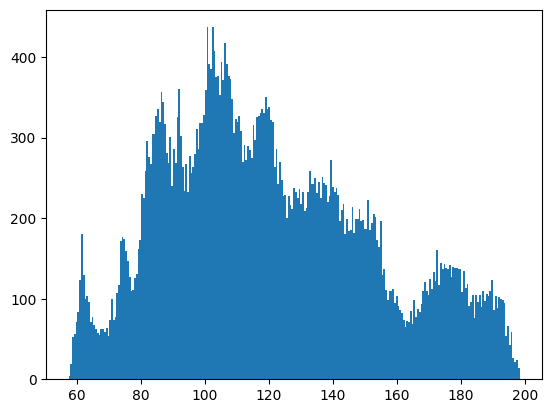

In [67]:
a = plt.hist(mean_img.ravel(), 255)

When we **subtract** an our mean image from something in the dataset, we **remove all of this information from it**. And that means that the rest of the information is really what is important for describing what is **unique** about it.

Let's take a single image (the second one (`faces[1]`)) and compare the histogram **before** and **after** ``normalizing our data``:

Text(0.5, 1.0, '(img - mean) distribution')

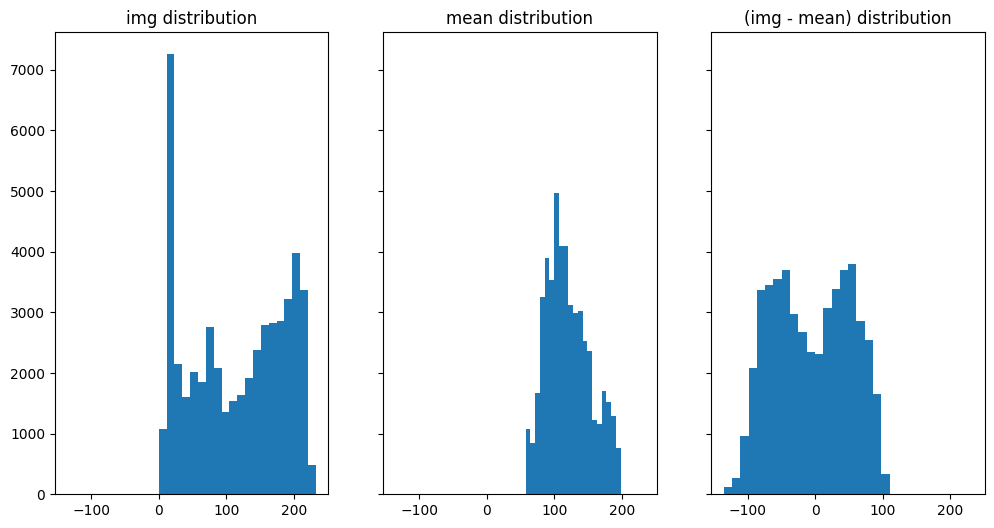

In [68]:
bins = 20
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axs[0].hist((faces[1]).ravel(), bins)
axs[0].set_title('img distribution')
axs[1].hist((mean_img).ravel(), bins)
axs[1].set_title('mean distribution')
axs[2].hist((faces[1] - mean_img).ravel(), bins)
axs[2].set_title('(img - mean) distribution')

What we can see from the histograms is the original image's distribution of values from 0 - 255. The mean image's data distribution is mostly **centered around the value 100**. 

When we look at the difference of the original image and the mean image as a histogram, we can see that the **distribution is now centered around 0**. What we are seeing is the distribution of values that were **above the mean image's intensity,** and which were **below** it. 

Images can have variations in lighting conditions, contrast, and overall brightness. By centering the data, you make the model less **sensitive to these variations** because the mean brightness is effectively subtracted, allowing the model to focus on **distinguishing image content** rather than absolute pixel values.

Let's take it one step further and complete the normalization by dividing by the standard deviation of our dataset:

Text(0.5, 1.0, '((img - mean) / std_dev) distribution')

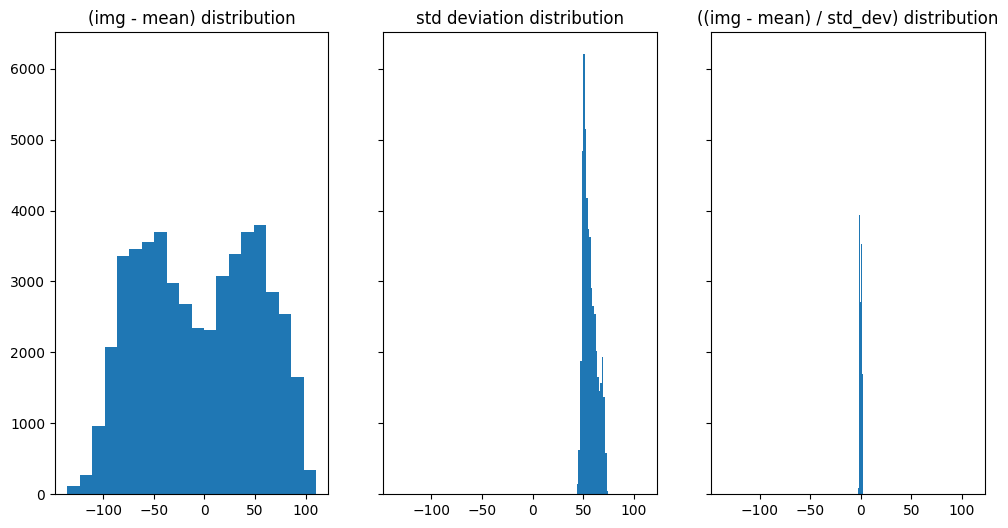

In [69]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axs[0].hist((faces[1] - mean_img).ravel(), bins)
axs[0].set_title('(img - mean) distribution')
axs[1].hist((std_img).ravel(), bins)
axs[1].set_title('std deviation distribution')
axs[2].hist(((faces[1] - mean_img) / std_img).ravel(), bins)
axs[2].set_title('((img - mean) / std_dev) distribution')

What we can see is that the data is in the range of -3 to 3, with the **bulk of the data centered around -1 to 1**. This is the effect of **normalizing** our data: most of the data will be around 0, where some deviations of it will follow between -3 to 3.

This has many of the advantages of **matching scale** as other normalisation methods. Additionally, standard deviation quantifies the spread or dispersion of data points. 

When you divide by the standard deviation, you're essentially expressing each data point in terms of how **many standard deviations it is away from the mean**. This helps to **emphasize the variation** and differences in the data. In contrast, dividing by the mean would simply scale all data points proportionally without considering their spread.

(-3.0, 3.0)

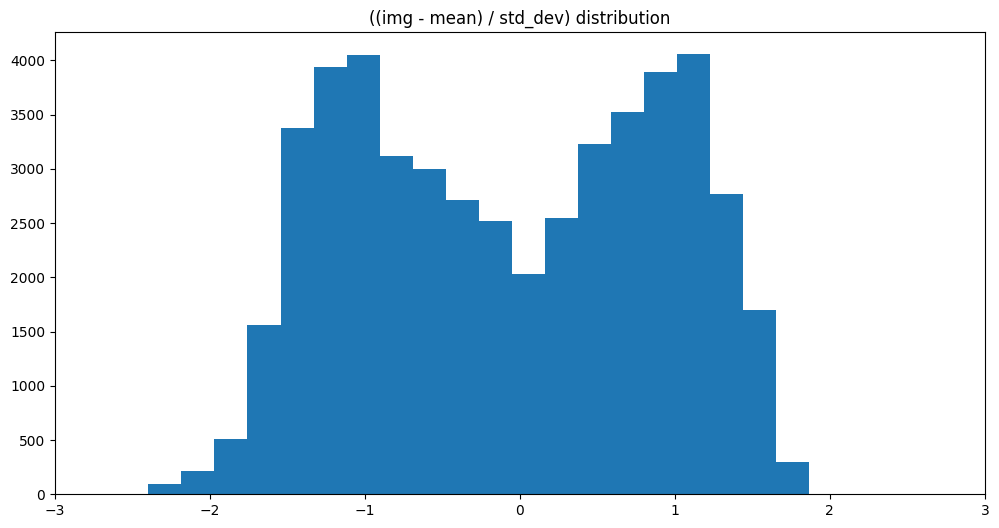

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(((faces[1] - mean_img) / std_img).ravel(), bins)
ax.set_title('((img - mean) / std_dev) distribution')
ax.set_xlim([-3, 3])

In [1]:
import cv2
from Animator import Animator
from mosaic import get_images
import numpy as np
from PIL import Image

an = Animator(300,300)

class MySketch:

    thumbnail_size = (an.width,an.height)
    dataset = get_images("images/aligned_faces", thumbnail_size)
    current_image = 0

    def __init__(self):
        an.start_loop(self.setup, self.draw)  

    def setup(self):
        return

    def draw(self):
        new_canvas = Image.new('RGB', (an.width, an.height))
        to_paste = self.dataset[np.random.randint(len(self.dataset))]
        coords = (0,0)
        new_canvas.paste(Image.fromarray(to_paste), coords)
        an.canvas = np.array(new_canvas)

MySketch()          









init
There have been 731 images found


KeyboardInterrupt: 